In [1]:
from __future__ import annotations

import pathlib

import polars
import seaborn
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)


Bad key axes.grid.axes in file matplotlibrc, line 17 ('axes.grid.axes: both')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.1/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
Bad value in file 'matplotlibrc', line 20 ("grid.color: '#6D6B71'"): Key grid.color: "'" does not look like a color arg


In [2]:
def load_data(directory: pathlib.Path) -> polars.DataFrame:
    dfs = []
    for run in directory.glob('**/results.csv'):
        try:
            df = polars.read_csv(run)
            if len(df) > 0:
                dfs.append(df)
        except Exception as e:
            print(f'Error loading {run}... skipping: {e}')
    return polars.concat(dfs)

In [3]:
data = load_data(pathlib.Path('../runs-prod/action-latency-v3/'))

In [4]:
results = data.filter(~polars.col('framework').str.contains('Hybrid'))
results = results.with_columns(
    polars.col('framework')
    .replace('AERIS[RedisExchange]', 'AERIS')
    .alias('framework'),
)
results

framework,trials,data_size_bytes,mean_latency_s,stdev_latency_s
str,i64,i64,f64,f64
"""AERIS""",50,1000,0.000543,0.000056
"""AERIS""",50,10000,0.000626,0.000024
"""AERIS""",50,100000,0.00081,0.000089
"""AERIS""",50,1000000,0.002645,0.000877
"""AERIS""",50,10000000,0.059862,0.004641
"""AERIS""",50,100000000,0.938258,0.002507
"""Dask""",50,1000,0.001186,0.001059
"""Dask""",50,10000,0.001508,0.000076
"""Dask""",50,100000,0.003356,0.000411


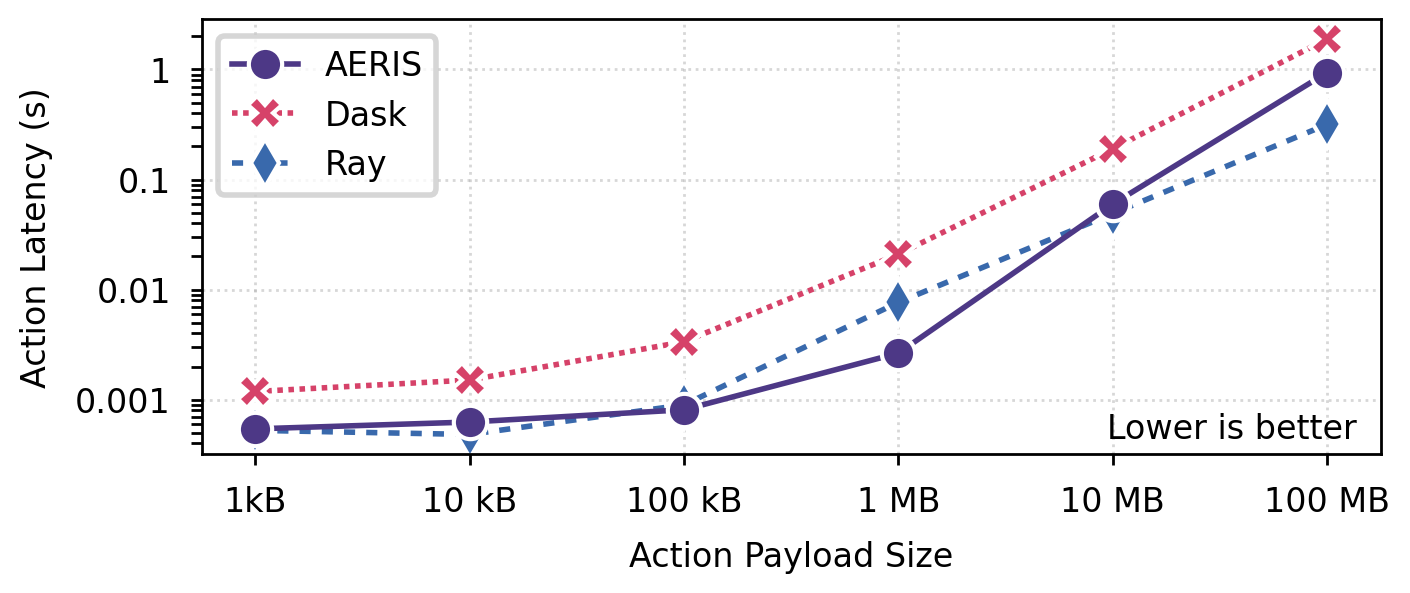

In [5]:
fig, axs = plt.subplots(1, 1)

xticks = sorted(set(results['data_size_bytes'].to_list()))
xtick_labels = ['1kB', '10 kB', '100 kB', '1 MB', '10 MB', '100 MB']
yticks = [0.001, 0.01, 0.1, 1]

dashes = {'Ray': (2, 2), 'Dask': (1, 1), 'AERIS': ()}
markers = {'Ray': 'd', 'Dask': 'X', 'AERIS': 'o'}
palette = {'Ray': '#3969AC', 'Dask': '#D64269', 'AERIS': '#4D3886'}

handle = seaborn.lineplot(
    results,
    x='data_size_bytes',
    y='mean_latency_s',
    hue='framework',
    hue_order=['Ray', 'Dask', 'AERIS'],
    style='framework',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs,
)
handles, _ = axs.get_legend_handles_labels()
axs.legend(handles=handles[::-1], title=None, labels=['AERIS', 'Dask', 'Ray'])
_ = handle.set(
    xscale='log',
    yscale='log',
    xlabel='Action Payload Size',
    ylabel='Action Latency (s)',
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels(xtick_labels)
axs.tick_params(axis='x', which='minor', bottom=False)
handle.set_yticks(yticks, minor=False)
handle.set_yticklabels([str(y) for y in yticks])

axs.annotate(
    'Lower is better',
    xy=(0.98, 0.02),
    xycoords=('axes fraction'),
    ha='right',
    va='bottom',
)

fig.set_size_inches(3.35, 1.25)
fig.savefig('figures/actor-action-latency.pdf')